In [9]:
from tabula import read_pdf
from tabula import convert_into

In [16]:
df = read_pdf('Category Summary JAN 2015.pdf', pages='all')

In [17]:
df

[     1/1/2015                 Unnamed: 0  Cash (thu)  new year  $2,249.22
 0         NaN                       2015         NaN       NaN        NaN
 1         NaN  Restaurant Cash & Credits         NaN       NaN        NaN
 2    1/2/2015                        NaN  Cash (fri)       NaN  $1,682.68
 3         NaN                       2015         NaN       NaN        NaN
 4         NaN  Restaurant Cash & Credits         NaN       NaN        NaN
 5    1/3/2015                        NaN  Cash (sat)       NaN  $2,550.18
 6         NaN                       2015         NaN       NaN        NaN
 7         NaN  Restaurant Cash & Credits         NaN       NaN        NaN
 8    1/4/2015                        NaN  Cash (sun)       NaN  $1,964.54
 9         NaN                       2015         NaN       NaN        NaN
 10        NaN  Restaurant Cash & Credits         NaN       NaN        NaN
 11   1/5/2015                        NaN  Cash (mon)       NaN  $1,029.82
 12        NaN           

In [11]:
convert_into("Category Summary JAN 2015.pdf", "output.csv", output_format="csv", pages='all')

In [14]:
df = pd.read_csv('output.csv', header=None)

In [15]:
df

,0,1,2,3,4
0,1/1/2015,NaN,Cash (thu),new year,"$2,249.22"
1,NaN,2015,NaN,NaN,NaN
2,NaN,Restaurant Cash & Credits,NaN,NaN,NaN
3,1/2/2015,NaN,Cash (fri),NaN,"$1,682.68"
4,NaN,2015,NaN,NaN,NaN
...,...,...,...,...,...
216,NaN,Restaurant Cash & Credits,NaN,NaN,NaN
217,1/30/2015,NaN,Tips,-$63.87,NaN
218,NaN,2015,NaN,NaN,NaN
219,NaN,Restaurant Cash & Credits,NaN,NaN,NaN


In [2]:
import sys
sys.path.append('py_scripts')
import helper_functions
from helper_functions import dict_months

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from pandas.plotting import lag_plot
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AR,ARResults
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima

# Data Manipulation

In [19]:
list_sales_report_urls = []
for month, url in dict_months.items():
    list_sales_report_urls.append(f'{month} = https://www.clover.com/reporting/sales-report?endTimestamp={url[1]}&startTimestamp={url[0]}')
    
# list_sales_report_urls

In [46]:
helper_functions.raw_file_clean(dict_months)

# Load Clean CSV

In [47]:
df = pd.read_csv('net_sales_total.csv')
# df = pd.read_csv('net_sales_total.csv', index_col='date', parse_dates=True)
df['date'] = pd.to_datetime(df['date'])
df

,date,total
0,2015-01-01,0.00
1,2015-01-02,0.00
2,2015-01-03,0.00
3,2015-01-04,0.00
4,2015-01-05,0.00
...,...,...
1826,2019-12-27,2325.50
1827,2019-12-28,3277.75
1828,2019-12-29,3919.75
1829,2019-12-30,2041.50


In [48]:
df = df[df['total']>100]

In [49]:
df

,date,total
13,2015-01-14,1200.00
14,2015-01-15,1497.25
15,2015-01-16,2624.75
16,2015-01-17,4190.00
17,2015-01-18,4329.50
...,...,...
1826,2019-12-27,2325.50
1827,2019-12-28,3277.75
1828,2019-12-29,3919.75
1829,2019-12-30,2041.50


In [50]:
daily_sales = df.set_index('date')
#df.set_index('date', inplace=True)

In [51]:
daily_sales

,total
date,
2015-01-14,1200.00
2015-01-15,1497.25
2015-01-16,2624.75
2015-01-17,4190.00
2015-01-18,4329.50
...,...
2019-12-27,2325.50
2019-12-28,3277.75
2019-12-29,3919.75


# EDA

              total
date               
2015-01-14  1200.00
2015-01-15  1497.25
2015-01-16  2624.75
2015-01-17  4190.00
2015-01-18  4329.50


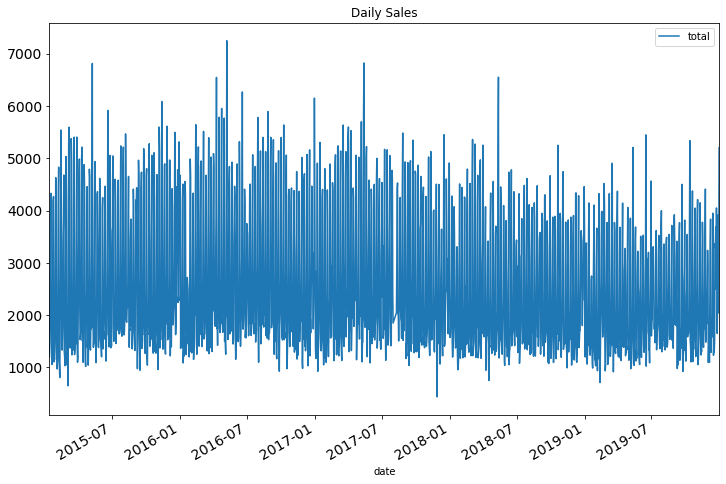

In [52]:
daily_sales.plot(figsize=(12,8), title = 'Daily Sales', fontsize=14)
print(daily_sales.head())

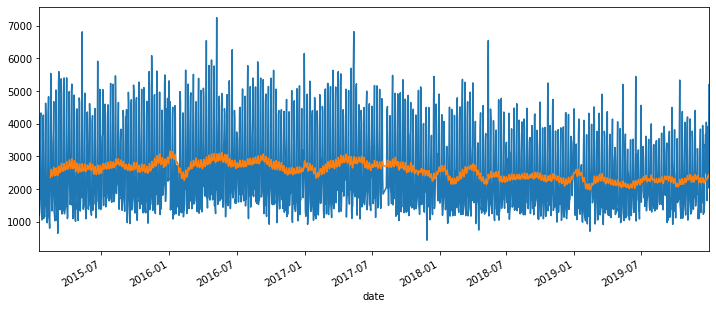

In [29]:
daily_sales['total'].plot(figsize=(12,5)).autoscale(axis='x',tight=True)
daily_sales.rolling(window=30).mean()['total'].plot();

<Figure size 432x288 with 0 Axes>

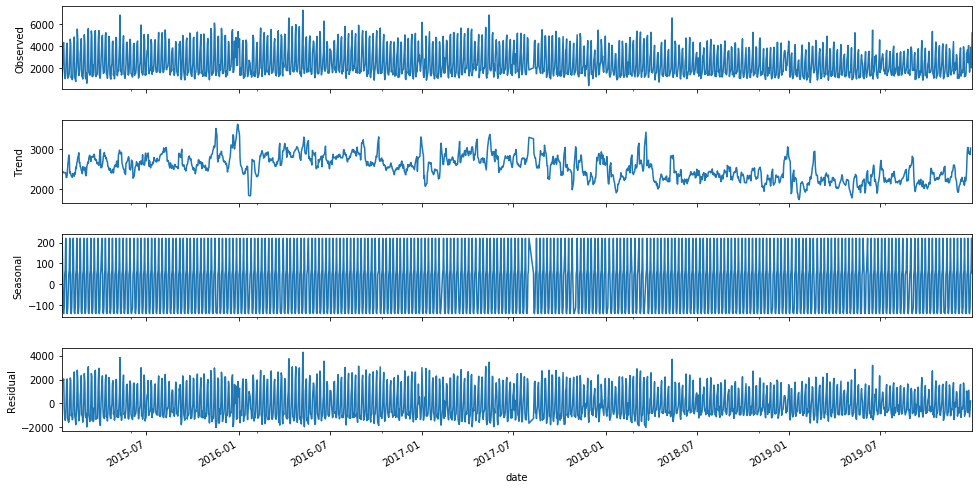

In [30]:
decomposition = seasonal_decompose(daily_sales['total'].dropna(inplace=False), freq=7)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15, 8)

In [31]:
def test_stationarity(timeseries, window):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries.iloc[window:], color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

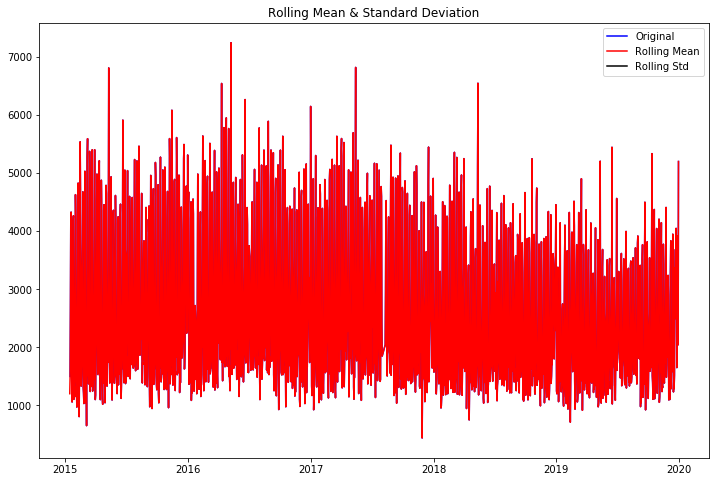

Results of Dickey-Fuller Test:
Test Statistic                   -4.837523
p-value                           0.000046
#Lags Used                       21.000000
Number of Observations Used    1752.000000
Critical Value (1%)              -3.434088
Critical Value (5%)              -2.863191
Critical Value (10%)             -2.567649
dtype: float64


In [32]:
test_stationarity(daily_sales['total'], 1)

### Log Transformation

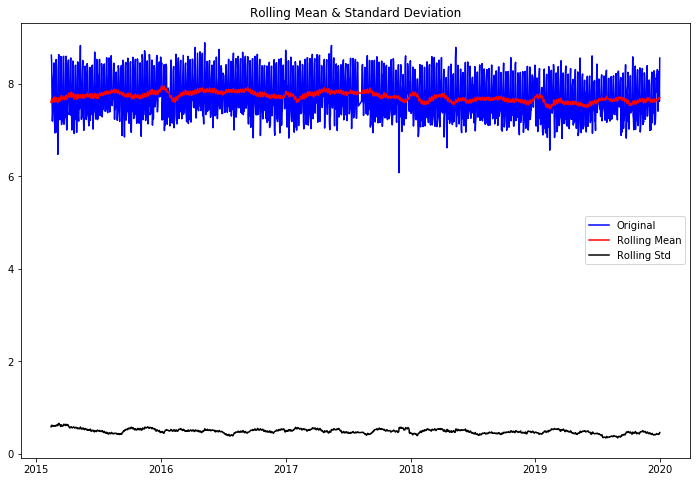

Results of Dickey-Fuller Test:
Test Statistic                   -5.493256
p-value                           0.000002
#Lags Used                       21.000000
Number of Observations Used    1752.000000
Critical Value (1%)              -3.434088
Critical Value (5%)              -2.863191
Critical Value (10%)             -2.567649
dtype: float64


In [121]:
daily_sales['natural_log'] = daily_sales.total.apply(lambda x: np.log(x))  
test_stationarity(daily_sales.natural_log, 30)

### First Difference

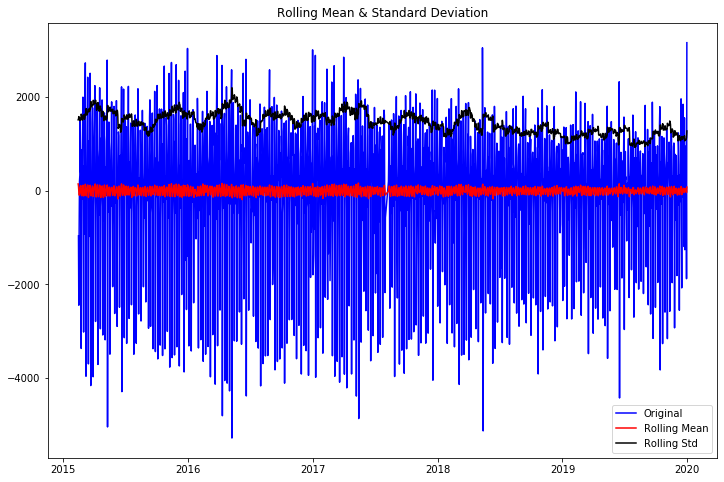

Results of Dickey-Fuller Test:
Test Statistic                -1.503977e+01
p-value                        9.630989e-28
#Lags Used                     1.900000e+01
Number of Observations Used    1.753000e+03
Critical Value (1%)           -3.434086e+00
Critical Value (5%)           -2.863190e+00
Critical Value (10%)          -2.567648e+00
dtype: float64


In [122]:
daily_sales['first_difference'] = daily_sales.total - daily_sales.total.shift(1)  
test_stationarity(daily_sales.first_difference.dropna(inplace=False),30)

### Seasonal Difference

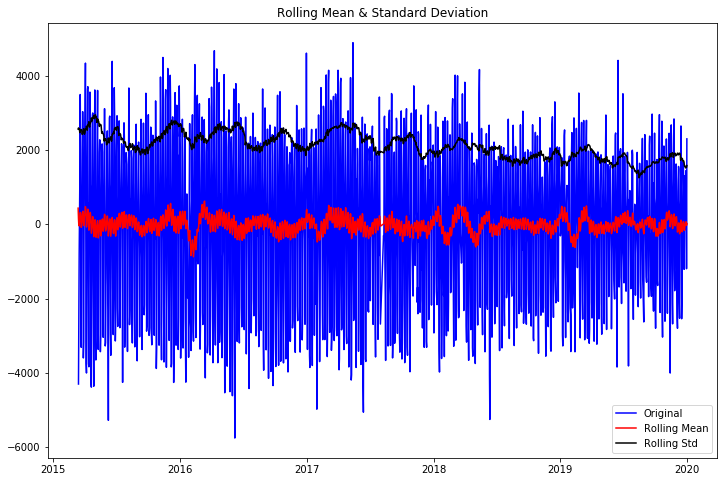

Results of Dickey-Fuller Test:
Test Statistic                -9.312852e+00
p-value                        1.037807e-15
#Lags Used                     2.500000e+01
Number of Observations Used    1.718000e+03
Critical Value (1%)           -3.434162e+00
Critical Value (5%)           -2.863224e+00
Critical Value (10%)          -2.567666e+00
dtype: float64


In [123]:
daily_sales['seasonal_difference'] = daily_sales.total - daily_sales.total.shift(30)
# daily_sales['seasonal_difference_dropna'] = daily_sales.seasonal_difference.dropna(inplace=False)
test_stationarity(daily_sales.seasonal_difference.dropna(inplace=False), 30)

### Seasonal Difference of the First Difference

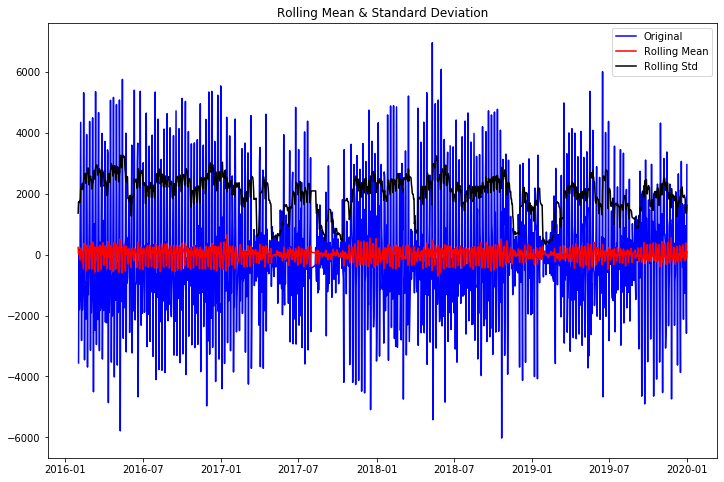

Results of Dickey-Fuller Test:
Test Statistic                -1.157279e+01
p-value                        3.073270e-21
#Lags Used                     2.400000e+01
Number of Observations Used    1.383000e+03
Critical Value (1%)           -3.435087e+00
Critical Value (5%)           -2.863632e+00
Critical Value (10%)          -2.567884e+00
dtype: float64


In [124]:
daily_sales['seasonal_first_difference'] = daily_sales.first_difference - daily_sales.first_difference.shift(365)  
test_stationarity(daily_sales.seasonal_first_difference.dropna(inplace=False), 12)

## Season Difference of the log first difference

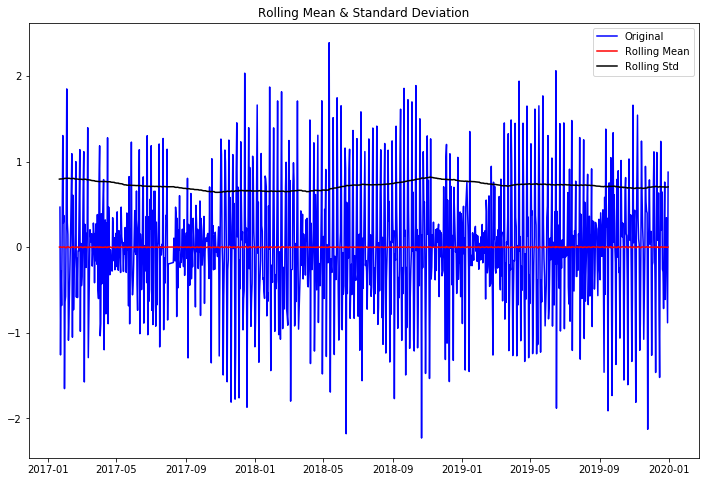

Results of Dickey-Fuller Test:
Test Statistic                -1.208000e+01
p-value                        2.243803e-22
#Lags Used                     2.400000e+01
Number of Observations Used    1.383000e+03
Critical Value (1%)           -3.435087e+00
Critical Value (5%)           -2.863632e+00
Critical Value (10%)          -2.567884e+00
dtype: float64


In [125]:
daily_sales['log_first_difference'] = daily_sales.natural_log - daily_sales.natural_log.shift(1)  
daily_sales['log_seasonal_first_difference'] = daily_sales.log_first_difference - daily_sales.log_first_difference.shift(365)  

# test_stationarity(monthly_sales.log_first_difference.dropna(inplace=False), 12)
test_stationarity(daily_sales.log_seasonal_first_difference.dropna(inplace=False), 365)


In [91]:
len(daily_sales)

1774

In [92]:
daily_sales.head()

,total,natural_log,first_difference,seasonal_difference,seasonal_first_difference,log_first_difference,log_seasonal_first_difference
date,,,,,,,
2015-01-14,1200.00,7.090077,NaN,NaN,NaN,NaN,NaN
2015-01-15,1497.25,7.311385,297.25,NaN,NaN,0.221309,NaN
2015-01-16,2624.75,7.872741,1127.50,NaN,NaN,0.561356,NaN
2015-01-17,4190.00,8.340456,1565.25,NaN,NaN,0.467715,NaN
2015-01-18,4329.50,8.373207,139.50,NaN,NaN,0.032751,NaN


# Train Test Split

In [172]:
train = daily_sales['total'].iloc[:1409]
test  = daily_sales['total'].iloc[1409:]

### Auto Arima

In [170]:
%%time
auto_arima(daily_sales['total'], n_jobs = -1).summary()

CPU times: user 41.6 s, sys: 137 ms, total: 41.7 s
Wall time: 26.4 s


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1774
Model:               SARIMAX(5, 1, 3)   Log Likelihood              -14315.069
Date:                Fri, 10 Jan 2020   AIC                          28650.139
Time:                        11:15:01   BIC                          28704.943
Sample:                             0   HQIC                         28670.385
                               - 1774                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -12.7918      5.773     -2.216      0.027     -24.107      -1.477
ar.L1          0.1588      0.052      3.040      0.002       0.056       0.261
ar.L2         -0.7251      0.040    -18.001      0.000      -0.804      -0.646
ar.L3         -0.3071      0.048     -6.410      0.000      -0.401      -0.213
ar.L4         -0.3738      0.028    -13.504      0.000      -0.428      -0.320
ar.L5         -0.5406      0.037    -14.526      0.000      -0.614      -0.468
ma.L1         -1.0946      0.060    -18.390      0.000      -1.211      -0.978
ma.L2          0.5872      0.084      6.985      0.000       0.422       0.752
ma.L3         -0.2820      0.044     -6.419      0.000      -0.368      -0.196
sigma2      7.136e+05   2.33e+04     30.631      0.000    6.68e+05    7.59e+05
===================================================================================
Ljung-Box (Q):                      749.19   Jarque-Bera (JB):               204.60
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                             0.10
Prob(H) (two-sided):                  0.04   Kurtosis:                         4.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [173]:
mod = sm.tsa.statespace.SARIMAX(train,
                                order=(5, 1, 3),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                           Statespace Model Results                           
Dep. Variable:                  total   No. Observations:                 1409
Model:               SARIMAX(5, 1, 3)   Log Likelihood              -11307.006
Date:                Fri, 10 Jan 2020   AIC                          22632.013
Time:                        11:17:13   BIC                          22679.230
Sample:                             0   HQIC                         22649.662
                               - 1409                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1936      0.046      4.233      0.000       0.104       0.283
ar.L2         -0.7917      0.036    -21.834      0.000      -0.863      -0.721
ar.L3         -0.2494      0.044     -5.652      0.0

In [179]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(5, 1, 3) Predictions')

In [178]:
title = 'Daily Sales'
ylabel='$'
xlabel=''

ax = daily_sales['total'].plot(legend=True,figsize=(20,10),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

ValueError: year 0 is out of range

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x11f2ffc20> (for post_execute):


ValueError: year 0 is out of range

ValueError: year 0 is out of range

In [152]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df['total'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -4.837523
p-value: 0.000046


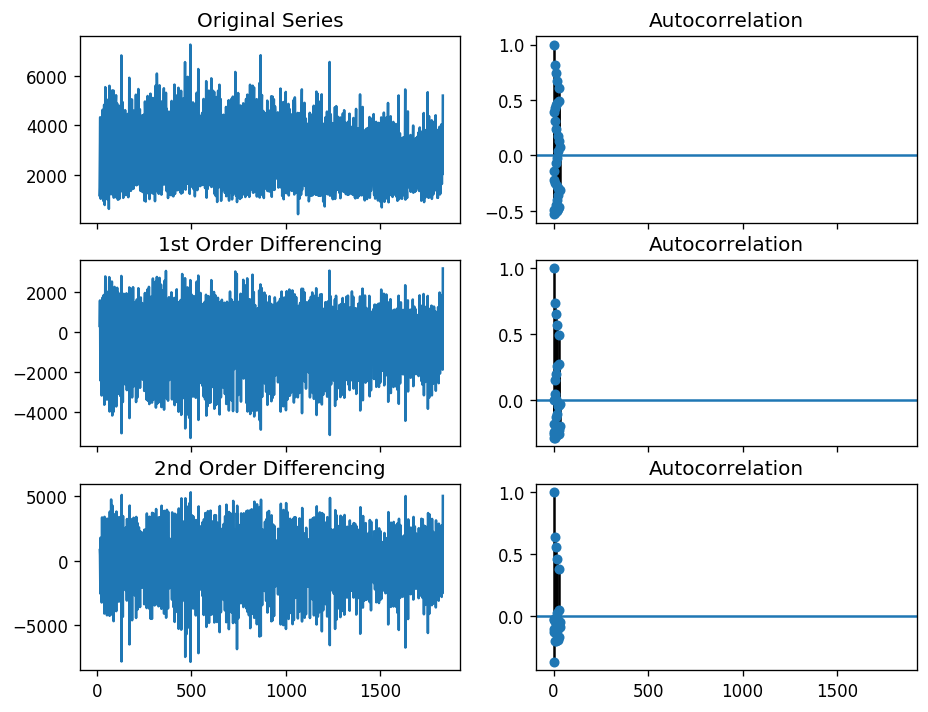

In [166]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.total); axes[0, 0].set_title('Original Series')
plot_acf(df.total, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.total.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.total.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.total.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.total.diff().diff().dropna(), ax=axes[2, 1])

plt.show()


In [165]:
from pmdarima.arima.utils import ndiffs
# df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)
y = df.total

## Adf Test
print(ndiffs(y, test='adf'))  # 2

# KPSS test
print(ndiffs(y, test='kpss'))  # 0

# PP test:
print(ndiffs(y, test='pp'))  # 2


0
1
0


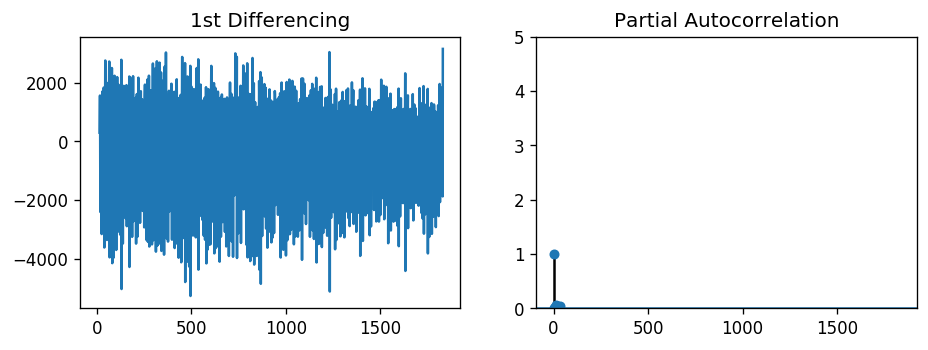

In [167]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.total.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.total.diff().dropna(), ax=axes[1])

plt.show()
